In [1]:
import pandas as pd 
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
#reading and concatenating datasets, removing missing values from the days of daylight saving
df2023 = pd.read_csv('Total Load - Day Ahead _ Actual_202301010000-202401010000.csv')
df2024 = pd.read_csv('Total Load - Day Ahead _ Actual_202401010000-202501010000.csv')
df = pd.concat([df2023, df2024]).reset_index(drop=True)
df = df[df['Actual Total Load [MW] - BZN|SK'] != '-']
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
#adding hour, workday/weekned and public holiday variables
public_holidays_sk = [dt.date(2023, 1, 1), dt.date(2023, 1, 6), dt.date(2023, 4, 7),
                  dt.date(2023, 4, 8), dt.date(2023, 4, 9), dt.date(2023, 4, 10), 
                  dt.date(2023, 5, 1), dt.date(2023, 5, 8), dt.date(2023, 7, 5),
                  dt.date(2023, 8, 29), dt.date(2023, 9, 1), dt.date(2023, 9, 15),
                  dt.date(2023, 11, 1), dt.date(2023, 11, 17),
                  dt.date(2023, 12, 24), dt.date(2023, 12, 25), dt.date(2023, 12, 26),
                  dt.date(2024, 1, 1), dt.date(2024, 1, 6)]

df['Time (CET/CEST)'] = df['Time (CET/CEST)'].apply(lambda x: dt.datetime.strptime(x.split(' - ')[0], "%d.%m.%Y %H:%M"))
df["dow"] = df["Time (CET/CEST)"].apply(lambda x: 1 if ((x.weekday() == 5) or (x.weekday() == 6)) else 0)
df["hour"] = df["Time (CET/CEST)"].apply(lambda x: x.hour)
df["holiday"] = df["Time (CET/CEST)"].apply(lambda x: 1 if x in public_holidays_sk else 0)

C:\Users\hrech\AppData\Local\Temp\ipykernel_2276\2243825143.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df["holiday"] = df["Time (CET/CEST)"].apply(lambda x: 1 if x in public_holidays_sk else 0)


In [4]:
#adding variable for the consumption from the day before
val_yesterday = []
for i in df["Time (CET/CEST)"].tolist():
    val = df[df['Time (CET/CEST)'] == (i - dt.timedelta(days=1))]["Actual Total Load [MW] - BZN|SK"].values
    try: 
        val = val[0]
    except:
        val = np.nan

    val_yesterday.append(val)

df['yesterday'] = val_yesterday

In [5]:
#dropping 1.01.2023, as there is no data from the previous day and the end of the data, so we have the whole days
df = df.iloc[24:-9, :]

In [6]:
#replace missing values with the mean of 2 closest in time
for i in df[df['yesterday'].isna()].index.tolist():
    df.loc[i, 'yesterday'] = (df.loc[i-1, 'yesterday'] + df.loc[i+1, 'yesterday'])/2

df.reset_index(drop=True, inplace=True)

In [7]:
#separating the last week for testing and dividing dataset 80:20 for training and validation
num_days = (df.shape[0] // 24) - 7
val_split = int(num_days * 0.8)*24
test_split = num_days*24

In [8]:
trainX, trainY = df.iloc[:val_split, 3:].values.astype(float), df.iloc[:val_split, 2].to_numpy().astype(float)
valX, valY = df.iloc[val_split:test_split, 3:].values.astype(float), df.iloc[val_split:test_split, 2].to_numpy().astype(float)
testX, testY = df.iloc[test_split:, 3:].values.astype(float), df.iloc[test_split:, 2].to_numpy().astype(float)

In [9]:
train_reg = xgb.DMatrix(trainX, trainY, enable_categorical=True)
val_reg = xgb.DMatrix(valX, valY, enable_categorical=True)
evals = [(train_reg, "train")]

In [10]:
params = {"objective": "reg:squarederror", "verbosity": 0}
evals_simple = {}
modelSimple = xgb.train(params=params, dtrain=train_reg, evals=evals, evals_result=evals_simple)

[0]	train-rmse:318.73337
[1]	train-rmse:245.17355
[2]	train-rmse:198.41022
[3]	train-rmse:169.96951
[4]	train-rmse:153.42554
[5]	train-rmse:144.03129
[6]	train-rmse:138.59478
[7]	train-rmse:135.28439
[8]	train-rmse:133.55692
[9]	train-rmse:132.10237


In [11]:
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "lambda":2}
evals_L2 = {}
modelL2 = xgb.train(params=params, dtrain=train_reg, evals=evals, evals_result=evals_L2,
                  num_boost_round=40)

[0]	train-rmse:392.48901
[1]	train-rmse:359.19983
[2]	train-rmse:329.59810
[3]	train-rmse:303.34747
[4]	train-rmse:280.10720
[5]	train-rmse:259.74866
[6]	train-rmse:241.75469
[7]	train-rmse:225.95241
[8]	train-rmse:212.28912
[9]	train-rmse:200.39368
[10]	train-rmse:190.12276
[11]	train-rmse:181.33215
[12]	train-rmse:173.71958
[13]	train-rmse:167.27462
[14]	train-rmse:161.74859
[15]	train-rmse:156.99045
[16]	train-rmse:152.97108
[17]	train-rmse:149.56463
[18]	train-rmse:146.69454
[19]	train-rmse:144.27303
[20]	train-rmse:142.24847
[21]	train-rmse:140.53416
[22]	train-rmse:139.10257
[23]	train-rmse:137.85908
[24]	train-rmse:136.78880
[25]	train-rmse:135.92579
[26]	train-rmse:135.16800
[27]	train-rmse:134.52554
[28]	train-rmse:133.96127
[29]	train-rmse:133.51867
[30]	train-rmse:132.94766
[31]	train-rmse:132.56393
[32]	train-rmse:132.08986
[33]	train-rmse:131.77260
[34]	train-rmse:131.39123
[35]	train-rmse:131.03889
[36]	train-rmse:130.76711


[37]	train-rmse:130.54400
[38]	train-rmse:130.31714
[39]	train-rmse:130.11293


In [12]:
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "lambda":10}
evals_L10 = {}
modelL10 = xgb.train(params=params, dtrain=train_reg, evals=evals, evals_result=evals_L10,
                  num_boost_round=40)

[0]	train-rmse:393.75229
[1]	train-rmse:361.43134
[2]	train-rmse:332.67314
[3]	train-rmse:307.01404
[4]	train-rmse:284.19961
[5]	train-rmse:264.08373
[6]	train-rmse:246.39364
[7]	train-rmse:230.80895
[8]	train-rmse:217.20088
[9]	train-rmse:205.32947
[10]	train-rmse:194.92163
[11]	train-rmse:185.98593
[12]	train-rmse:178.30210
[13]	train-rmse:171.67060
[14]	train-rmse:165.94347
[15]	train-rmse:161.04881
[16]	train-rmse:156.87665
[17]	train-rmse:153.23776
[18]	train-rmse:150.17597
[19]	train-rmse:147.56049
[20]	train-rmse:145.34008
[21]	train-rmse:143.44393
[22]	train-rmse:141.79105
[23]	train-rmse:140.41073
[24]	train-rmse:139.22380
[25]	train-rmse:138.22020
[26]	train-rmse:137.37067
[27]	train-rmse:136.63967
[28]	train-rmse:135.94269
[29]	train-rmse:135.37908
[30]	train-rmse:134.88101
[31]	train-rmse:134.39223
[32]	train-rmse:133.95389
[33]	train-rmse:133.54273
[34]	train-rmse:133.19872
[35]	train-rmse:132.90788
[36]	train-rmse:132.62899
[37]	train-rmse:132.34097
[38]	train-rmse:132.11

In [13]:
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "lambda":100}
evals_L100 = {}
modelL100 = xgb.train(params=params, dtrain=train_reg, evals=evals, evals_result=evals_L100,
                  num_boost_round=40)

[0]	train-rmse:398.38747
[1]	train-rmse:370.13615
[2]	train-rmse:344.60589
[3]	train-rmse:321.92939
[4]	train-rmse:301.42438
[5]	train-rmse:283.23594
[6]	train-rmse:266.89770
[7]	train-rmse:252.56946
[8]	train-rmse:239.57741
[9]	train-rmse:227.78754
[10]	train-rmse:217.26078
[11]	train-rmse:208.03620
[12]	train-rmse:199.73997
[13]	train-rmse:192.48194
[14]	train-rmse:185.90336
[15]	train-rmse:180.28579
[16]	train-rmse:175.35454
[17]	train-rmse:170.82518
[18]	train-rmse:166.93606
[19]	train-rmse:163.34683
[20]	train-rmse:160.23030
[21]	train-rmse:157.49081
[22]	train-rmse:154.97728
[23]	train-rmse:152.91090
[24]	train-rmse:151.00180
[25]	train-rmse:149.38243
[26]	train-rmse:147.81365
[27]	train-rmse:146.46811
[28]	train-rmse:145.27059
[29]	train-rmse:144.20896
[30]	train-rmse:143.23115
[31]	train-rmse:142.39292
[32]	train-rmse:141.54714
[33]	train-rmse:140.76947
[34]	train-rmse:140.11660
[35]	train-rmse:139.54023
[36]	train-rmse:139.02906
[37]	train-rmse:138.53901
[38]	train-rmse:138.06

In [14]:
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "alpha":2}
evals_A2 = {}
modelA2 = xgb.train(params=params, dtrain=train_reg, evals=evals, evals_result=evals_A2,
                  num_boost_round=40)

[0]	train-rmse:392.24224
[1]	train-rmse:358.75347
[2]	train-rmse:328.99486
[3]	train-rmse:302.59996
[4]	train-rmse:279.42102
[5]	train-rmse:258.88216
[6]	train-rmse:240.94729
[7]	train-rmse:225.25283
[8]	train-rmse:211.50381
[9]	train-rmse:199.68482
[10]	train-rmse:189.39020
[11]	train-rmse:180.56567
[12]	train-rmse:172.99944
[13]	train-rmse:166.58769
[14]	train-rmse:161.10587
[15]	train-rmse:156.37681
[16]	train-rmse:152.40989
[17]	train-rmse:149.05632
[18]	train-rmse:146.22964
[19]	train-rmse:143.85891
[20]	train-rmse:141.85794
[21]	train-rmse:140.13933
[22]	train-rmse:138.70095
[23]	train-rmse:137.51336
[24]	train-rmse:136.48682
[25]	train-rmse:135.61586
[26]	train-rmse:134.86052
[27]	train-rmse:134.18977
[28]	train-rmse:133.58081
[29]	train-rmse:133.04720
[30]	train-rmse:132.64261
[31]	train-rmse:132.20449
[32]	train-rmse:131.84373
[33]	train-rmse:131.54091
[34]	train-rmse:131.18768
[35]	train-rmse:130.89339
[36]	train-rmse:130.59676
[37]	train-rmse:130.30961
[38]	train-rmse:130.09

In [15]:
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "alpha":10}
evals_A10 = {}
modelA10 = xgb.train(params=params, dtrain=train_reg, evals=evals, evals_result=evals_A10,
                  num_boost_round=40)

[0]	train-rmse:392.24663
[1]	train-rmse:358.76177
[2]	train-rmse:329.00653
[3]	train-rmse:302.61459
[4]	train-rmse:279.44086
[5]	train-rmse:258.89787
[6]	train-rmse:240.96688
[7]	train-rmse:225.27594
[8]	train-rmse:211.60955
[9]	train-rmse:199.67485
[10]	train-rmse:189.42176
[11]	train-rmse:180.57073
[12]	train-rmse:173.06410
[13]	train-rmse:166.64201
[14]	train-rmse:161.14773
[15]	train-rmse:156.47792
[16]	train-rmse:152.50299
[17]	train-rmse:149.17982
[18]	train-rmse:146.38024
[19]	train-rmse:143.97943
[20]	train-rmse:141.96361
[21]	train-rmse:140.29263
[22]	train-rmse:138.80874
[23]	train-rmse:137.60438
[24]	train-rmse:136.60157
[25]	train-rmse:135.71685
[26]	train-rmse:135.00040
[27]	train-rmse:134.31472
[28]	train-rmse:133.74361
[29]	train-rmse:133.11159
[30]	train-rmse:132.63655
[31]	train-rmse:132.24482
[32]	train-rmse:131.85555
[33]	train-rmse:131.53561
[34]	train-rmse:131.17190
[35]	train-rmse:130.87127
[36]	train-rmse:130.55626
[37]	train-rmse:130.32715
[38]	train-rmse:130.13

In [16]:
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "alpha":100}
evals_A100 = {}
modelA100 = xgb.train(params=params, dtrain=train_reg, evals=evals, evals_result=evals_A100,
                  num_boost_round=40)

[0]	train-rmse:392.29609
[1]	train-rmse:358.85461
[2]	train-rmse:329.13835
[3]	train-rmse:302.80384
[4]	train-rmse:279.50416
[5]	train-rmse:259.11808
[6]	train-rmse:241.11190
[7]	train-rmse:225.32646
[8]	train-rmse:211.69699
[9]	train-rmse:199.87399
[10]	train-rmse:189.59834
[11]	train-rmse:180.82431
[12]	train-rmse:173.29282
[13]	train-rmse:166.82302
[14]	train-rmse:161.33012
[15]	train-rmse:156.68620
[16]	train-rmse:152.72475
[17]	train-rmse:149.36749
[18]	train-rmse:146.53047
[19]	train-rmse:144.13950
[20]	train-rmse:142.11321
[21]	train-rmse:140.41770
[22]	train-rmse:138.97179
[23]	train-rmse:137.76779
[24]	train-rmse:136.77311
[25]	train-rmse:135.84645
[26]	train-rmse:135.07215
[27]	train-rmse:134.41753
[28]	train-rmse:133.88070
[29]	train-rmse:133.33779
[30]	train-rmse:132.92766
[31]	train-rmse:132.53472
[32]	train-rmse:132.11155
[33]	train-rmse:131.77925
[34]	train-rmse:131.42971
[35]	train-rmse:131.15505
[36]	train-rmse:130.91176
[37]	train-rmse:130.64231
[38]	train-rmse:130.39

[]

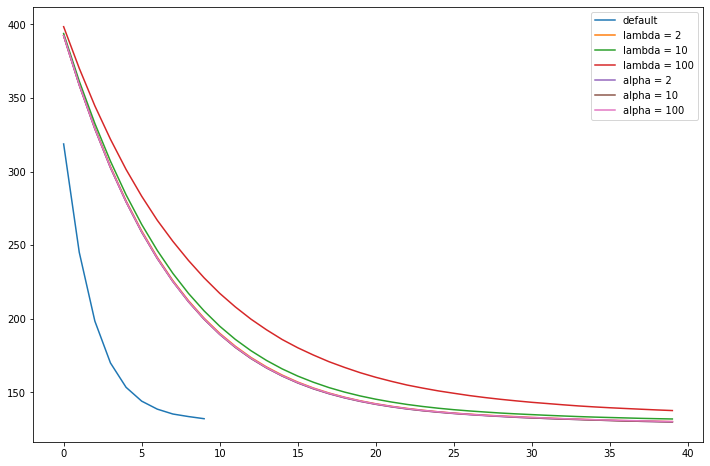

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(evals_simple['train']['rmse'], label="default")
plt.plot(evals_L2['train']['rmse'], label="lambda = 2")
plt.plot(evals_L10['train']['rmse'], label="lambda = 10")
plt.plot(evals_L100['train']['rmse'], label="lambda = 100")
plt.plot(evals_A2['train']['rmse'], label="alpha = 2")
plt.plot(evals_A10['train']['rmse'], label="alpha = 10")
plt.plot(evals_A100['train']['rmse'], label="alpha = 100")
plt.legend()
plt.plot()

In [18]:
def predictions_batches(model, testX):
    predictions = []
    previous = None

    for i in range(testX.shape[0]//24):
        testBatch = testX[(i)*24:(i+1)*24, :]
        if i != 0:
            testBatch[:, -1] = previous 
        
        test_reg = xgb.DMatrix(testBatch, enable_categorical=True)
        previous = model.predict(test_reg).tolist()
        predictions.extend(previous)

    return np.array(predictions)

def mape(realY, predY):
    return np.mean(np.abs((realY - predY) / realY)) * 100

In [19]:
predSimple = predictions_batches(modelSimple, valX)
predL2 = predictions_batches(modelL2, valX)
predL10 = predictions_batches(modelL10, valX)
predL100 = predictions_batches(modelL100, valX)
predA2 = predictions_batches(modelA2, valX)
predA10 = predictions_batches(modelA10, valX)
predA100 = predictions_batches(modelA100, valX)

print(mape(valY, predA2))
print(mape(valY, predA10))
print(mape(valY, predA100))
print(mape(valY, predL2))
print(mape(valY, predL10))
print(mape(valY, predL100))

13.223565483556918
13.231747048672386
13.157686316227373
13.29670176948898
13.212294586029566
12.967699443075812


### separating workdays and weekends/public holidays

In [27]:
dfTrain = df.iloc[:test_split, 2:]
dfTrain.head()

,Actual Total Load [MW] - BZN|SK,dow,hour,holiday,yesterday
0,2196.0,0,0,0,2339.0
1,2090.0,0,1,0,2201.0
2,2089.0,0,2,0,2211.0
3,2083.0,0,3,0,2164.0
4,2208.0,0,4,0,2152.0


In [36]:
dfHoliday = dfTrain[(dfTrain['dow'] == 1) | (dfTrain['holiday'] == 1)].loc[:, ['Actual Total Load [MW] - BZN|SK', 'hour', 'yesterday']].reset_index(drop=True)
dfWork = dfTrain[(dfTrain['dow'] != 1) & (dfTrain['holiday'] != 1)].loc[:, ['Actual Total Load [MW] - BZN|SK', 'hour', 'yesterday']].reset_index(drop=True)

In [37]:
val_holiday = int((dfHoliday.shape[0]//24) * 0.8) * 24
val_work = int((dfWork.shape[0]//24) * 0.8) * 24

trainHolX, trainHolY = dfHoliday.iloc[:val_holiday, 1:].values.astype(float), dfHoliday.iloc[:val_holiday, 0].to_numpy().astype(float)
valHolX, valHolY = dfHoliday.iloc[val_holiday:, 1:].values.astype(float), dfHoliday.iloc[val_holiday:, 0].to_numpy().astype(float)
trainWorkX, trainWorkY = dfWork.iloc[:val_work, 1:].values.astype(float), dfWork.iloc[:val_work, 0].to_numpy().astype(float)
valWorkX, valWorkY = dfWork.iloc[val_work:, 1:].values.astype(float), dfWork.iloc[val_work:, 0].to_numpy().astype(float)

In [38]:
train_work = xgb.DMatrix(trainWorkX, trainWorkY, enable_categorical=True)
evals = [(train_work, "train")]
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "alpha":10}
modelWork = xgb.train(params=params, dtrain=train_work, evals=evals, num_boost_round=40)

[0]	train-rmse:381.30945
[1]	train-rmse:348.94640
[2]	train-rmse:320.26389
[3]	train-rmse:294.91712
[4]	train-rmse:272.58548
[5]	train-rmse:252.99713
[6]	train-rmse:235.88049
[7]	train-rmse:220.98434
[8]	train-rmse:208.04907
[9]	train-rmse:196.94920
[10]	train-rmse:187.41086
[11]	train-rmse:179.26850
[12]	train-rmse:172.35828
[13]	train-rmse:166.38769
[14]	train-rmse:161.35145
[15]	train-rmse:157.09011
[16]	train-rmse:153.47867
[17]	train-rmse:150.47815
[18]	train-rmse:147.94178
[19]	train-rmse:145.84111
[20]	train-rmse:144.07927
[21]	train-rmse:142.52339
[22]	train-rmse:141.27694
[23]	train-rmse:140.17725
[24]	train-rmse:139.26839
[25]	train-rmse:138.42767
[26]	train-rmse:137.51247
[27]	train-rmse:136.95637
[28]	train-rmse:136.46250
[29]	train-rmse:136.06714
[30]	train-rmse:135.70031
[31]	train-rmse:135.32304
[32]	train-rmse:135.02469
[33]	train-rmse:134.73161
[34]	train-rmse:134.34429
[35]	train-rmse:134.02419
[36]	train-rmse:133.75030
[37]	train-rmse:133.49088
[38]	train-rmse:133.19

In [39]:
train_holiday = xgb.DMatrix(trainHolX, trainHolY, enable_categorical=True)
evals = [(train_holiday, "train")]
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "alpha":10}
modelHoliday = xgb.train(params=params, dtrain=train_holiday, evals=evals, num_boost_round=40)

[0]	train-rmse:301.41328
[1]	train-rmse:277.14364
[2]	train-rmse:255.65669
[3]	train-rmse:236.68853
[4]	train-rmse:220.00139
[5]	train-rmse:205.36724
[6]	train-rmse:192.55629
[7]	train-rmse:181.35648
[8]	train-rmse:171.65078
[9]	train-rmse:163.27403
[10]	train-rmse:156.01418
[11]	train-rmse:149.76493
[12]	train-rmse:144.45099
[13]	train-rmse:139.83646
[14]	train-rmse:135.88367
[15]	train-rmse:132.56719
[16]	train-rmse:129.64583
[17]	train-rmse:127.14048
[18]	train-rmse:125.06273
[19]	train-rmse:123.30020
[20]	train-rmse:121.77344
[21]	train-rmse:120.44773
[22]	train-rmse:119.26071
[23]	train-rmse:118.25467
[24]	train-rmse:117.27331
[25]	train-rmse:116.52230
[26]	train-rmse:115.88737
[27]	train-rmse:115.25148
[28]	train-rmse:114.71229
[29]	train-rmse:114.12968
[30]	train-rmse:113.60117
[31]	train-rmse:113.06361
[32]	train-rmse:112.59371
[33]	train-rmse:112.24294
[34]	train-rmse:111.85899
[35]	train-rmse:111.38561
[36]	train-rmse:111.03491
[37]	train-rmse:110.66505
[38]	train-rmse:110.39

In [40]:
predHol = predictions_batches(modelHoliday, valHolX)
predWork = predictions_batches(modelWork, valWorkX)

In [41]:
predCombined = predHol.tolist()
predCombined.extend(predWork.tolist())
predCombined = np.array(predCombined)

valCombined = valHolY.tolist()
valCombined.extend(valWorkY.tolist())
valCombined = np.array(valCombined)

mape(valCombined, predCombined)

13.478371010612216

### testing

In [21]:
#training the selected model on train + val data
trainX, trainY = df.iloc[:test_split, 3:].values.astype(float), df.iloc[:test_split, 2].to_numpy().astype(float)
train_reg = xgb.DMatrix(trainX, trainY, enable_categorical=True)
params = {"objective": "reg:squarederror", "verbosity": 0, "eta":0.1, "lambda":100}
model = xgb.train(params=params, dtrain=train_reg, evals=evals, num_boost_round=40)

[0]	train-rmse:402.34014
[1]	train-rmse:372.34624
[2]	train-rmse:345.71850
[3]	train-rmse:321.60995
[4]	train-rmse:300.14613
[5]	train-rmse:281.20350
[6]	train-rmse:264.33163


[7]	train-rmse:249.48197
[8]	train-rmse:236.23521
[9]	train-rmse:224.70362
[10]	train-rmse:214.31851
[11]	train-rmse:205.00717
[12]	train-rmse:197.14485
[13]	train-rmse:189.98235
[14]	train-rmse:183.96990
[15]	train-rmse:178.43978
[16]	train-rmse:173.83267
[17]	train-rmse:169.65480
[18]	train-rmse:165.82545
[19]	train-rmse:162.62543
[20]	train-rmse:159.95598
[21]	train-rmse:157.61808
[22]	train-rmse:155.39009
[23]	train-rmse:153.34263
[24]	train-rmse:151.60542
[25]	train-rmse:150.18295
[26]	train-rmse:148.82824
[27]	train-rmse:147.73312
[28]	train-rmse:146.77300
[29]	train-rmse:145.75502
[30]	train-rmse:144.87212
[31]	train-rmse:144.06237
[32]	train-rmse:143.34238
[33]	train-rmse:142.74517
[34]	train-rmse:142.13917
[35]	train-rmse:141.60584
[36]	train-rmse:141.15961
[37]	train-rmse:140.74826
[38]	train-rmse:140.33884
[39]	train-rmse:140.01107


In [22]:
predTest = predictions_batches(model, testX)

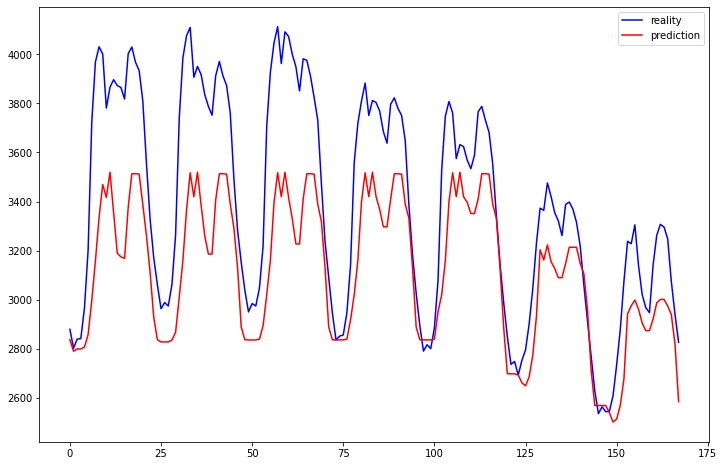

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(testY, color="blue", label="reality")
plt.plot(predTest, color="red", label="prediction")
plt.legend()

In [24]:
mape(testY, predTest)

8.036361949499899